In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45881,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:36343,Total threads: 4
Dashboard: /proxy/35911/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:37527,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

In [4]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
lon_slice  = slice(-256, -246) 
lat_slice  = slice(-67.5, -63)

#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly').sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

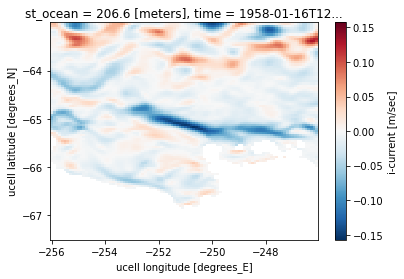

In [5]:
#test after doing the mean depth
#u_speed[0,0,...].plot()
u_speed[0,0,...].plot()

In [6]:
u_speed

,Array,Chunk
Bytes,263.88 MiB,259.38 kiB
Shape,"(732, 9, 105, 100)","(1, 8, 83, 100)"
Count,2468548 Tasks,2928 Chunks
Type,float32,numpy.ndarray


In [7]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 200
zlevel2 = 500

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'xu_ocean':u_speed.xu_ocean},axis=[1])

# import bathymetry:
hu = cc.querying.getvar(iaf_cycle3,'hu',master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu,other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
u_speed = (u_speed*thickness).sum('st_ocean')/thickness.sum('st_ocean')

## Remove Climatology

In [8]:
# calculate monthly climatology
climatology = u_speed.groupby('time.month').mean('time')

# remove seasonal signal
u_speed_seasonal_removed = (u_speed - climatology)

In [9]:
#load the variable
u_speed = u_speed.load()
u_speed_seasonal_removed = u_speed_seasonal_removed.load()
##test
#np.amin(temp_400m_za)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encounte

#### Here's a step-by-step explanation of what's happening in the code:

#### ekman_con has the dimensions (time=732, y=100, x=100).
#### climatology is calculated by taking the mean of ekman_con along the time dimension for each month. This results in climatology having dimensions (month=12, y=100, x=100).
#### climatology is then broadcasted to match the shape of ekman_con along the time dimension, so that it now has dimensions (time=732, month=12, y=100, x=100).
#### The broadcasted climatology is then subtracted from ekman_con, resulting in ekman_con_seasonal_removed having dimensions (time=732, month=12, y=100, x=100). This means that the month dimension is preserved in the result.

#### Because of that, we can probably remove the month dimension to not cause issues later on.

In [10]:
# select a single month and drop the 'month' dimension
u_speed_seasonal_removed = u_speed_seasonal_removed.isel(month=0).drop('month')

### Apparently they are, so my procedure should have worked. I will try detrending and rolling a 12 month mean through the new data

### First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [11]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [12]:
# Note we need to first detrend the data:
u_speed_r = u_speed_seasonal_removed.rolling(time=12, center=True).mean()
u_speed_justroll = u_speed.rolling(time=12, center=True).mean()

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [13]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [14]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### creating the averages for peaks and lows

In [15]:
#full mean
uspeed_con_avg = u_speed_r.mean('time')
uspeed_con_avg = uspeed_con_avg.load()

#mean of all high peaks together
uspeed_high_avg=u_speed_r[top_id].mean('time')
uspeed_high_avg = uspeed_high_avg.load()

#mean of all low peaks together
u_speed_low_avg=u_speed_r[bt_id].mean('time')
u_speed_low_avg = u_speed_low_avg.load()

In [16]:
#full mean, for those without climatology applied
uspeed_con_avg2 = u_speed_justroll.mean('time')
uspeed_con_avg2 = uspeed_con_avg2.load()

#mean of all high peaks together
uspeed_high_avg2=u_speed_justroll[top_id].mean('time')
uspeed_high_avg2 = uspeed_high_avg2.load()

#mean of all low peaks together
u_speed_low_avg2=u_speed_justroll[bt_id].mean('time')
u_speed_low_avg2 = u_speed_low_avg2.load()

### TRANSECT ASC 

In [17]:
# get temp and salt to calculate lines:
temp = cc.querying.getvar(iaf_cycle3,'temp',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly') - 273.15
temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

salt = cc.querying.getvar(iaf_cycle3,'salt',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


In [18]:
#get U general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
u_speed = u_speed.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

#### PLOT MAP TO CHOOSE TRANSECT

In [19]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
#temp_slice = temp.sel(st_ocean=400,method='nearest').mean('time')
#temp_slice = temp_slice.load()
u_slice = u_speed.sel(st_ocean=400,method='nearest').mean('time')
u_slice = u_slice.load()

# also get bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
ht = ht.load()

# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

[Text(-256.0, 0, '104'),
 Text(-254.0, 0, '105'),
 Text(-252.0, 0, '106'),
 Text(-250.0, 0, '107'),
 Text(-248.0, 0, '108')]

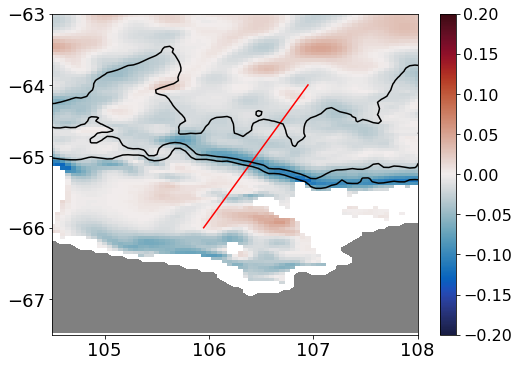

In [20]:
# define transect start and end points:
# Change these values until you get the transect you want:

fontsize=18
lat0 = -66
lat1=-64
lon0 = -252.1
lon1 = -250.1

fig=plt.figure(figsize=(18,13))
ax0=plt.subplot(221) 
# plot temperature:
plt.pcolormesh(u_slice.xu_ocean,u_slice.yu_ocean,u_slice, cmap=cmocean.balance,
              vmin=-.2,vmax=.2)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))
plt.tick_params(labelsize=fontsize)
# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r')
plt.xlim((-255, -248))
plt.ylim((-67.5, -63))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

cbar.ax.tick_params(labelsize=16)
cbar.ax.tick_params(labelsize=16)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

#save_results_to = '/g/data/jk72/ns3783/Round8'
#plt.savefig(save_results_to + 'transect_lat_IAF3.png', dpi=120,bbox_inches='tight', pad_inches=0.1)
#plt.savefig(save_results_to + 'transect_asc_trajectory+temp.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [21]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yu_ocean = u_speed.yu_ocean

# get latitude of points along transect:
lat_transect = yu_ocean.sel(yu_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yu_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yu_ocean')

# Extract temp and salt along transect:
temp_transect = temp.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect = salt.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# Extract u/v along transect:
u_speed_trans = u_speed.sel(xu_ocean = lon_transect, yu_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect*0 + temp_transect.st_ocean
lat_array = temp_transect*0 + temp_transect.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)
sigma0 = gsw.sigma0(salt_abs,temp_transect)
# convert back to xarray for multiplying later:
sigma0 = xr.DataArray(sigma0,
                      coords = [temp_transect.time, temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['time','st_ocean','yt_ocean'])

In [22]:
# load data before plotting:
sigma0 = sigma0.load()
temp_transect = temp_transect.load()
u_speed_trans = u_speed_trans.load()

2024-08-12 12:04:14,234 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


## Remove Climatology

In [23]:
# calculate monthly climatology
climatology = u_speed_trans.groupby('time.month').mean('time')

# remove seasonal signal
u_speed_trans_seasonal_removed = (u_speed_trans - climatology)

In [24]:
# select a single month and drop the 'month' dimension
u_speed_trans_seasonal_removed = u_speed_trans_seasonal_removed.isel(month=0).drop('month')

In [25]:
# Note we need to first detrend the data:
#ekman_con_detrended = detrend_dim(ekman_con_seasonal_removed,'time') #commented out because if we run this line the average panel is 0. 
u_speed_trans_r = u_speed_trans_seasonal_removed.rolling(time=12, center=True).mean()
u_speed_trans_just_roll = u_speed_trans.rolling(time=12, center=True).mean()

## Calculate the means to plot the transects afterwards

In [26]:
temp_mean = temp_transect.mean('time')
sigma0_mean = sigma0.mean('time')
u_speed_mean = u_speed_trans_r.mean('time')

u_speed_mean_justroll = u_speed_trans_just_roll.mean('time')

In [27]:
#mean of all high peaks together
uspeed_trans_top=u_speed_trans_r[top_id].mean('time')
uspeed_trans_top = uspeed_trans_top.load()

sigma0_top= sigma0[top_id].mean('time')
sigma0_top = sigma0_top.load()

#mean of all low peaks together
uspeed_trans_bt=u_speed_trans_r[bt_id].mean('time')
uspeed_trans_bt = uspeed_trans_bt.load()

sigma0_bt= sigma0[bt_id].mean('time')
sigma0_bt = sigma0_bt.load()

In [28]:
#mean of all high peaks together
uspeed_trans_top2 =u_speed_trans_just_roll[top_id].mean('time')
uspeed_trans_top2 = uspeed_trans_top2.load()

#mean of all low peaks together
uspeed_trans_bt2 = u_speed_trans_just_roll[bt_id].mean('time')
uspeed_trans_bt2 = uspeed_trans_bt2.load()


## PLOT COMPOSITES FOR ASC + TRANSECT

In [29]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

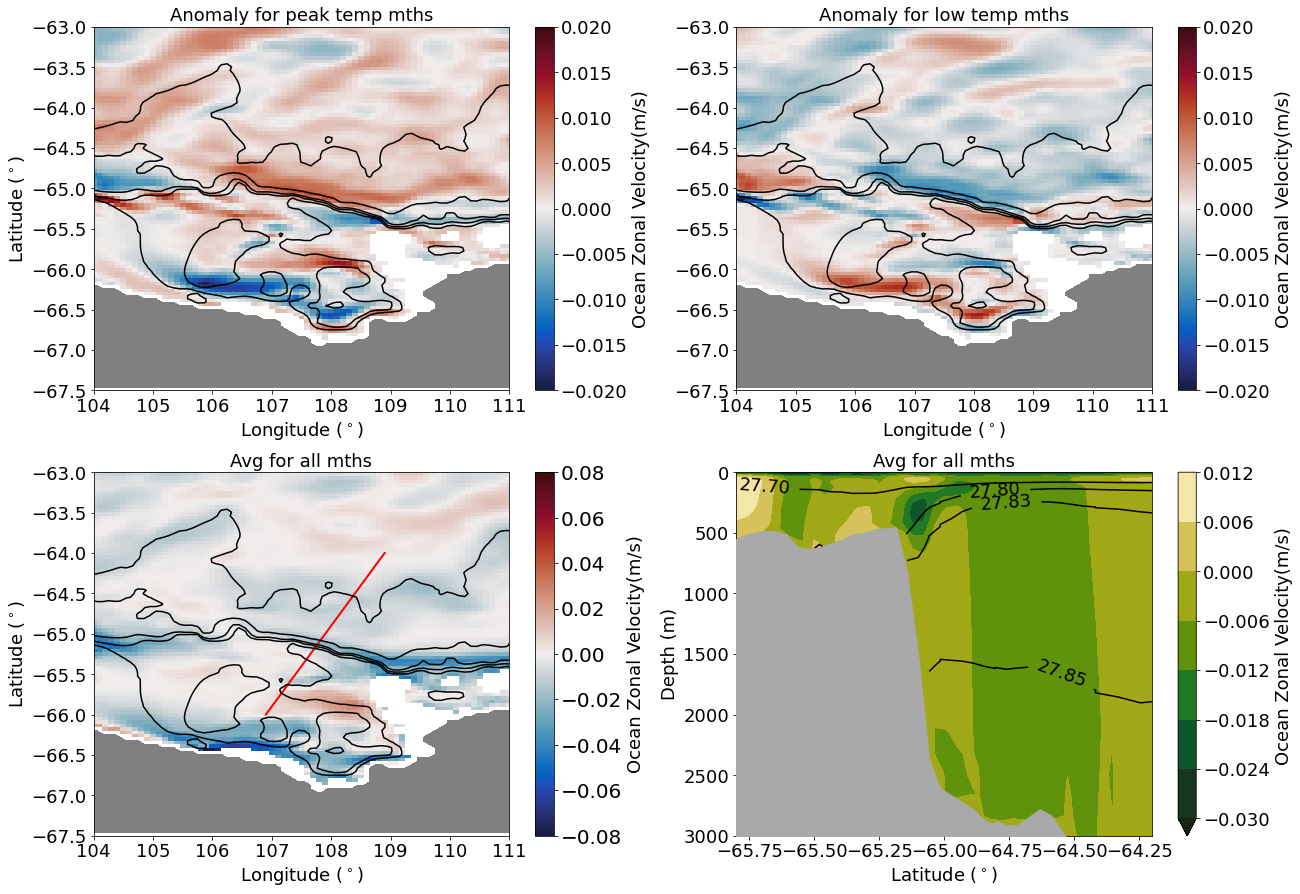

In [30]:
### test new values
fontsize=18

#for nt in range(0,nframes):
fig=plt.figure(figsize=(18, 18))#fig=plt.figure(figsize=(18, 13))
fig.subplots_adjust(top=0.88)

t_high = uspeed_high_avg-uspeed_con_avg;
t_low = u_speed_low_avg-uspeed_con_avg;
ax0=plt.subplot(321) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.02,vmax=.02)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.02,vmax=.02)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
####
ax0=plt.subplot(3,2,3)    
pc = plt.pcolormesh(uspeed_con_avg.xu_ocean,uspeed_con_avg.yu_ocean,
                        uspeed_con_avg, cmap = cmocean.balance, 
                        vmin=-.08,vmax=.08)
plt.plot([-252.1,-250.1],[-66,-64],'r',linewidth=2)

plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

####
ax0=plt.subplot(3,2,4) 
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# plot temperature:
pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
           cmap = cmocean.speed_r,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Avg for all mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_mean.yt_ocean,sigma0_mean.st_ocean,sigma0_mean,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')



fig.tight_layout()
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#filestr = figdir+'/Fig10_ASC_removed_climatology.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

### Create the inset for new fig 10

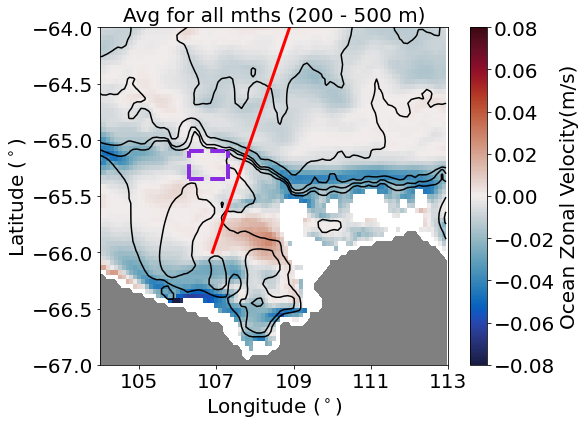

In [31]:
## new fig 10 to put together with EKE Fig. 

### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(uspeed_con_avg.xu_ocean,uspeed_con_avg.yu_ocean,
                        uspeed_con_avg, cmap = cmocean.balance, 
                        vmin=-.08,vmax=.08)
plt.title('Avg for all mths (200 - 500 m)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)

##TO INCLUDE THE ASC TRANSECT AND TBOX POSITIONS
#plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth=3)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=4)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=4)

fig.tight_layout()
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#filestr = figdir+'/Fig10_asc_inset.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

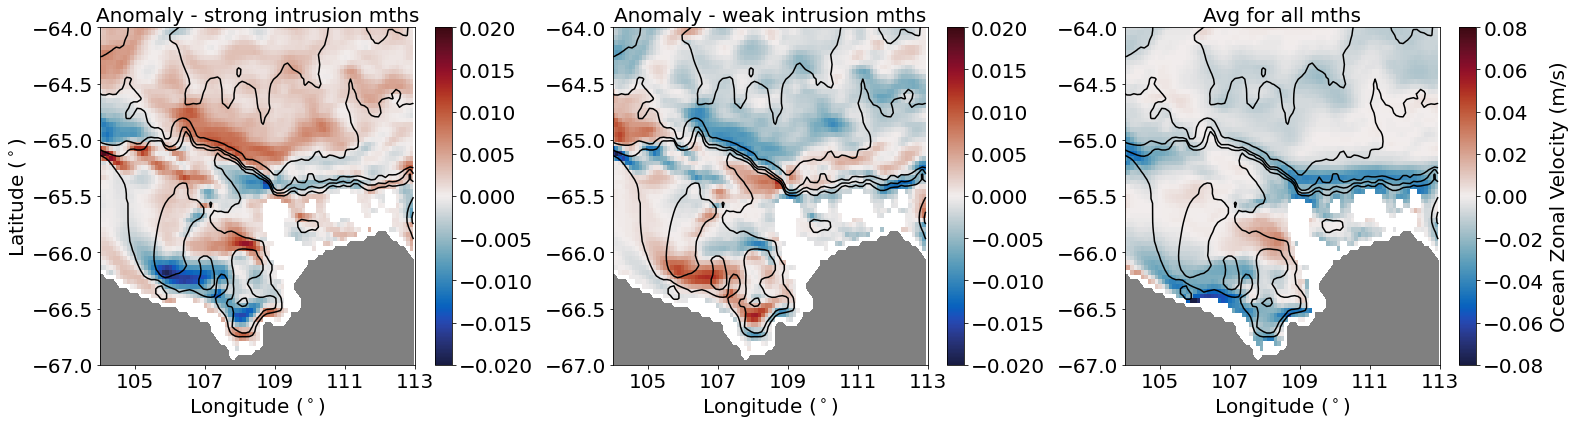

2024-08-12 12:07:05,059 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 12:08:49,770 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [32]:
## new fig 10 to put together with EKE Fig. 

### test new values
fontsize=20

#for nt in range(0,nframes):
fig=plt.figure(figsize=(22, 22))
fig.subplots_adjust(top=0.88)

t_high = uspeed_high_avg-uspeed_con_avg;
t_low = u_speed_low_avg-uspeed_con_avg;
ax0=plt.subplot(431) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.02,vmax=.02)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.02,vmax=.02)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
#cbar.set_label(r'EKE (cm$^{2}$/s$^{2}$)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(4,3,3)    
pc = plt.pcolormesh(uspeed_con_avg.xu_ocean,uspeed_con_avg.yu_ocean,
                        uspeed_con_avg, cmap = cmocean.balance, 
                        vmin=-.08,vmax=.08)
plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)

##TO INCLUDE THE ASC TRANSECT AND TBOX POSITIONS
#plt.plot([-252.7,-252.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-251.7,-251.7],[-65.35, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.1, -65.1],color='blueviolet',linestyle='--',linewidth=5)
#plt.plot([-252.7,-251.7],[-65.35, -65.35],color='blueviolet',linestyle='--',linewidth=5)
#
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='blueviolet',linestyle='--',linewidth=4)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -246))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ocean Zonal Velocity (m/s)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-252+359,-250+359,-248+359,-246+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/Fig10_asc_anomaly_clim.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')


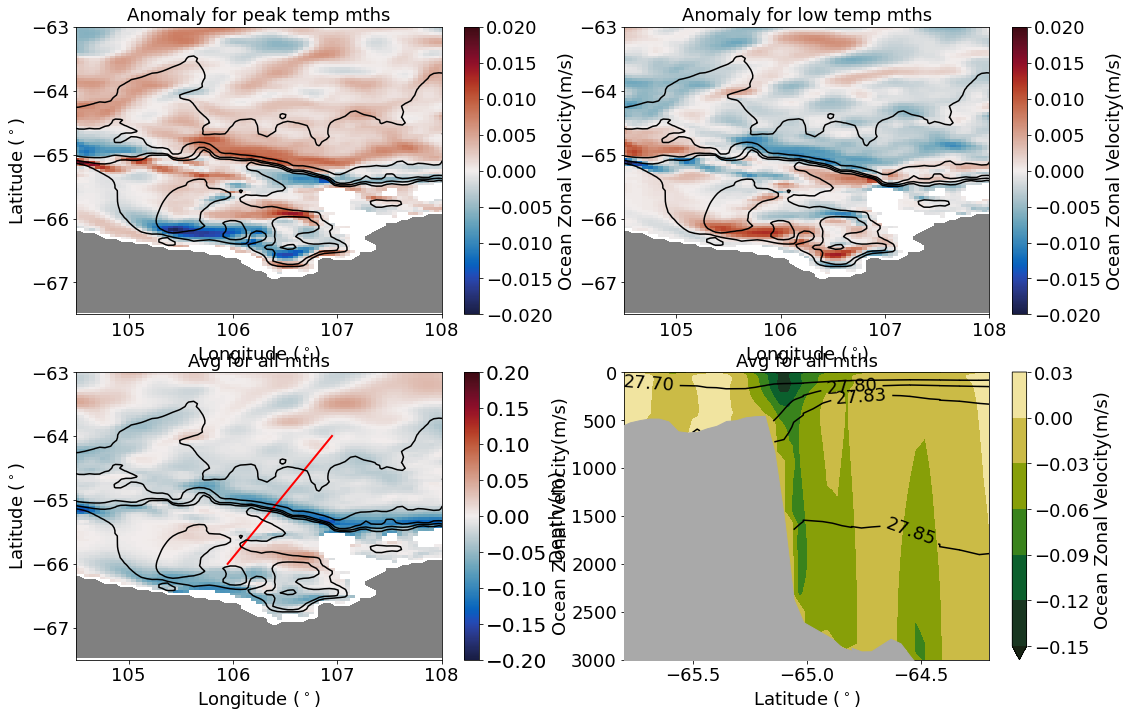

In [33]:
### test new values
fontsize=18

#for nt in range(0,nframes):
fig=plt.figure(figsize=(18, 18))#fig=plt.figure(figsize=(18, 13))
fig.subplots_adjust(top=0.88)

t_high = uspeed_high_avg2-uspeed_con_avg2;
t_low = u_speed_low_avg2-uspeed_con_avg2;
ax0=plt.subplot(321) 
pc = plt.pcolormesh(t_high.xu_ocean,t_high.yu_ocean,
                        t_high, cmap = cmocean.balance, 
                        vmin=-.02,vmax=.02)
#plt.title('Anomaly for Str Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for peak temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
# plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

ax0=plt.subplot(3,2,2)      
pc = plt.pcolormesh(t_low.xu_ocean,t_low.yu_ocean,
                       t_low, cmap = cmocean.balance, 
                        vmin=-.02,vmax=.02)
#plt.title('Anomaly for Weak Heat Flux (Y) yrs',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
#plt.plot([-252.7,-250.1],[-64.8,-65.2],color='yellow',linestyle='--',linewidth=3)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
####
ax0=plt.subplot(3,2,3)    
pc = plt.pcolormesh(uspeed_con_avg2.xu_ocean,uspeed_con_avg2.yu_ocean,
                        uspeed_con_avg2, cmap = cmocean.balance, 
                        vmin=-.2,vmax=.2)
plt.plot([-252.1,-250.1],[-66,-64],'r',linewidth=2)

plt.title('Avg for all mths',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[500,700,1000,2000,3000],colors='k',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
#plt.title(mth[nt] +' '+ str(yr[nt]),fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67.5, -63))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

####
ax0=plt.subplot(3,2,4) 
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# plot temperature:
pcm = plt.contourf(u_speed_mean_justroll.yu_ocean,u_speed_mean_justroll.st_ocean,u_speed_mean_justroll.fillna(0),
           cmap = cmocean.speed_r,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Avg for all mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_mean.yt_ocean,sigma0_mean.st_ocean,sigma0_mean,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')



#fig.tight_layout()
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#filestr = figdir+'/Fig10_ASC_rolling_mean_only.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

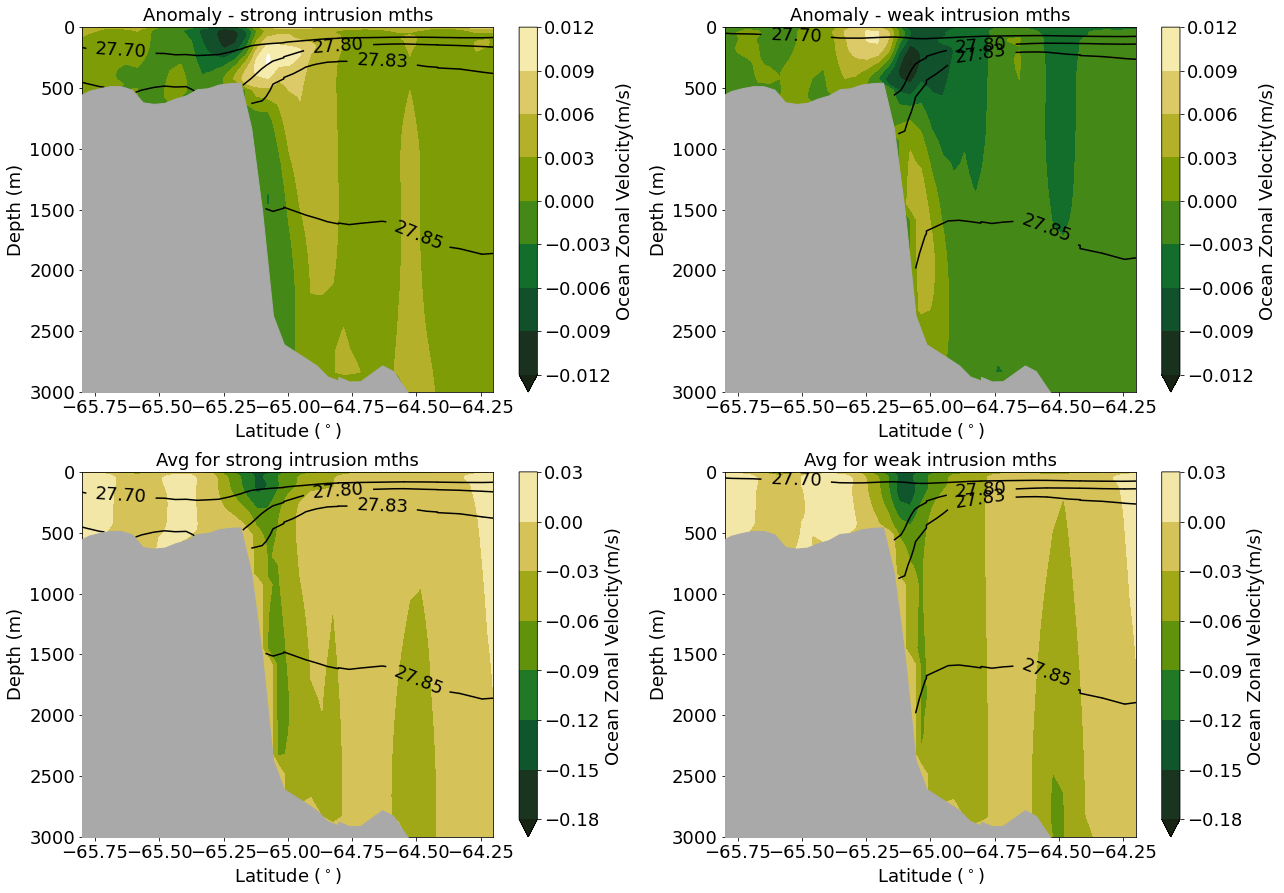

2024-06-19 00:14:31,162 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [34]:
### test new values
fontsize=18

#for nt in range(0,nframes):
fig=plt.figure(figsize=(18, 18))#fig=plt.figure(figsize=(18, 13))
fig.subplots_adjust(top=0.88)


####
t_high = uspeed_trans_top2-u_speed_mean_justroll;
t_low = uspeed_trans_bt2-u_speed_mean_justroll;
ax0=plt.subplot(321) 
# plot temperature:
pcm = plt.contourf(t_high.yu_ocean,t_high.st_ocean,t_high.fillna(0),
           cmap = cmocean.speed_r,levels=np.linspace(-0.012, 0.012, 9), vmin=-0.012, vmax=0.012,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Anomaly - strong intrusion mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_top.yt_ocean,sigma0_top.st_ocean,sigma0_top,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax0=plt.subplot(3,2,2)      
pcm = plt.contourf(t_low.yu_ocean,t_low.st_ocean,t_low.fillna(0),
           cmap = cmocean.speed_r,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Anomaly - weak intrusion mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_bt.yt_ocean,sigma0_bt.st_ocean,sigma0_bt,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


###
ax0=plt.subplot(3,2,3) 
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# plot temperature:
pcm = plt.contourf(uspeed_trans_top2.yu_ocean,uspeed_trans_top2.st_ocean,uspeed_trans_top2.fillna(0),
                  cmap = cmocean.speed_r,levels=np.linspace(-0.18, 0.03, 8), vmin=-0.18, vmax=0.03,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Avg for strong intrusion mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_top.yt_ocean,sigma0_top.st_ocean,sigma0_top,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

ax0=plt.subplot(3,2,4) 
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# plot temperature:
pcm = plt.contourf(uspeed_trans_bt2.yu_ocean,uspeed_trans_bt2.st_ocean,uspeed_trans_bt2.fillna(0),
           cmap = cmocean.speed_r,extend='min')
#plt.clim(,4)
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Avg for weak intrusion mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_bt.yt_ocean,sigma0_bt.st_ocean,sigma0_bt,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

##
fig.tight_layout()

#fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
filestr = figdir+'/Fig10extra_ASC_rolling_mean_only.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

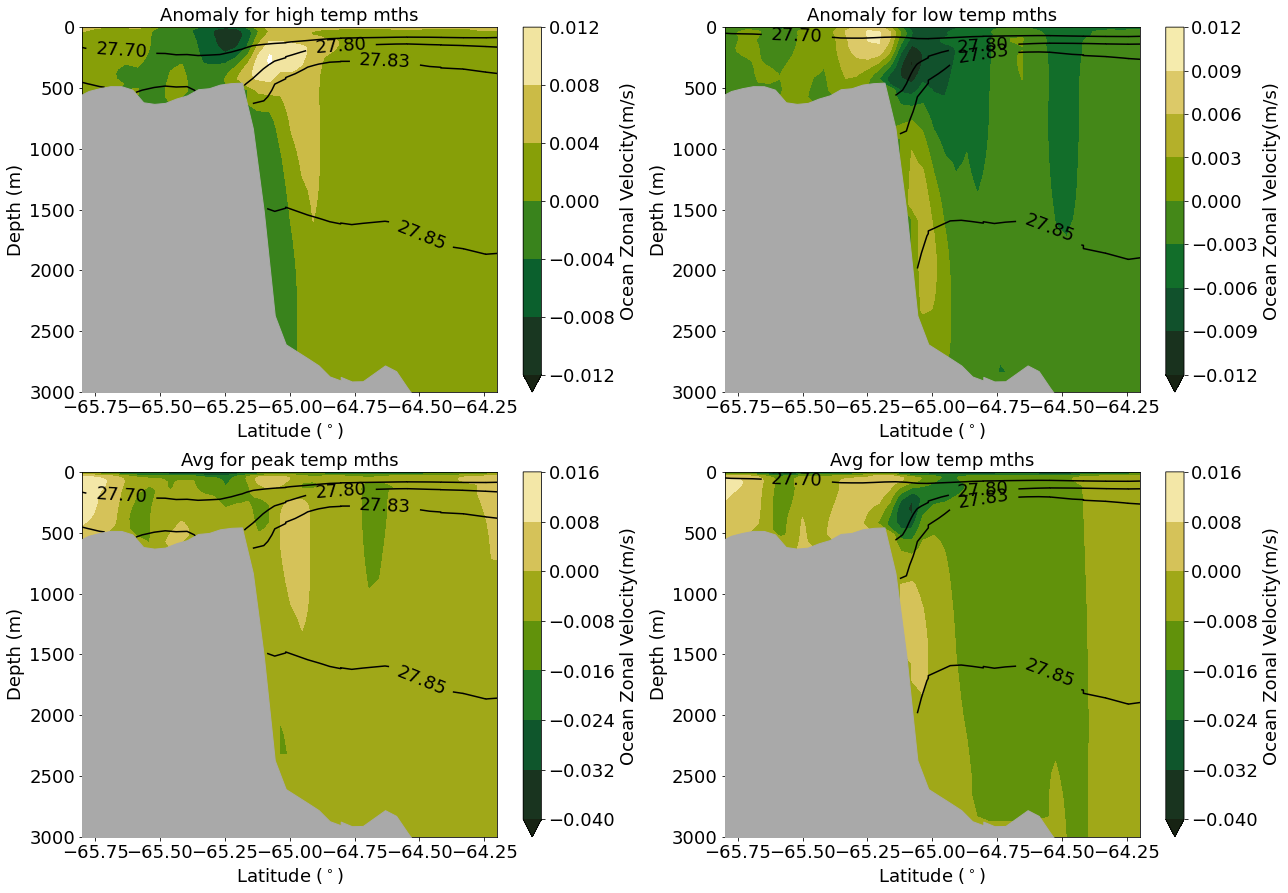

In [86]:
### test new values
fontsize=18

#for nt in range(0,nframes):
fig=plt.figure(figsize=(18, 18))#fig=plt.figure(figsize=(18, 13))
fig.subplots_adjust(top=0.88)


####
t_high = uspeed_trans_top-u_speed_mean;
t_low = uspeed_trans_bt-u_speed_mean;
ax0=plt.subplot(321) 
# plot temperature:
pcm = plt.contourf(t_high.yu_ocean,t_high.st_ocean,t_high.fillna(0),
           cmap = cmocean.speed_r,levels=np.linspace(-0.012, 0.012, 7), vmin=-0.012, vmax=0.012,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Anomaly for high temp mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_top.yt_ocean,sigma0_top.st_ocean,sigma0_top,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax0=plt.subplot(3,2,2)      
pcm = plt.contourf(t_low.yu_ocean,t_low.st_ocean,t_low.fillna(0),
           cmap = cmocean.speed_r,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Anomaly for low temp mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_bt.yt_ocean,sigma0_bt.st_ocean,sigma0_bt,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


###
ax0=plt.subplot(3,2,3) 
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# plot temperature:
pcm = plt.contourf(uspeed_trans_top.yu_ocean,uspeed_trans_top.st_ocean,uspeed_trans_top.fillna(0),
           cmap = cmocean.speed_r,levels=np.linspace(-0.04, 0.016, 8), vmin=-0.04, vmax=0.016,extend='min')
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Avg for peak temp mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_top.yt_ocean,sigma0_top.st_ocean,sigma0_top,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

ax0=plt.subplot(3,2,4) 
# choose density contours that work for your transect:
density_contours = [27.7,27.8,27.83,27.85,27.9]

# plot temperature:
pcm = plt.contourf(uspeed_trans_bt.yu_ocean,uspeed_trans_bt.st_ocean,uspeed_trans_bt.fillna(0),
           cmap = cmocean.speed_r,levels=np.linspace(-0.04, 0.016, 8), vmin=-0.04, vmax=0.016,extend='min')
#plt.clim(,4)
#pcm = plt.contourf(u_speed_mean.yu_ocean,u_speed_mean.st_ocean,u_speed_mean.fillna(0),
#           cmap = cmocean.speed, norm = norm,levels=levels,extend='both')

plt.tick_params(labelsize=fontsize)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((3000,0))
plt.xlim((-65.8,-64.2))
plt.ylabel('Depth (m)',fontsize=fontsize)
plt.xlabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('Avg for low temp mths',fontsize=fontsize)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'Ocean Zonal Velocity(m/s)', fontsize = fontsize,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_bt.yt_ocean,sigma0_bt.st_ocean,sigma0_bt,density_contours,
           colors='k',zorder=2 ,fontsize=fontsize)
plt.clabel(cont, inline=1, fontsize=fontsize,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

##
fig.tight_layout()

#fig.tight_layout()
#figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures/'
#filestr = figdir+'/Fig10extra_ASC_removed_climatology.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [40]:
np.min(uspeed_trans_top)

<xarray.DataArray 'u' ()>
array(-0.16546619)

In [41]:
np.min(uspeed_trans_bt)

<xarray.DataArray 'u' ()>
array(-0.18780054)

In [42]:

np.min(u_speed_mean)

<xarray.DataArray 'u' ()>
array(-0.17664887)